# Backtesting strategy selection on PnL 

The aim of this notebook is to show strategy backtesting using LUSID's derived portfolio functionality. In this notebook we will compare the performance of a US technology sector equity portfolio under two seperate scenarios. In the first scenario, the portfolio will be weighted towards "Google". In the second scenario, the portfolio will be weighted towards "Netflix". We will then compare PnL results. 

From a LUSID perspective, we will complete the following:

(1) Setup the LUSID environment. <br>

(2) Create our first portfolio. <br>

(3) Load our FANG (Facebook, Apple, Netflix, Google) instrument master. <br>

(4) Upsert initial holdings - the portfolio will have a 55% of NAV weighting to "Google". <br>

(5) Upsert quotes to cover a 9 month period (1 Jan 2019 to 30 Sep 2019). <br>

(6) Run aggregration on Google heavy portfolio. <br>

(7) Plot the results of this portfolio on a graph. <br>

(8) Did we make the correct allocation decision? By using LUSID's derived portfolios, we can wind back time and check performance of the portfolio if we allocated 55% to Netflix instead of Google. <br>

(9) Plot and compare time series. <br>


# Step 1: Import packages and initialize LUSID environment

In [1]:
# Import LUSID
import lusid
import lusid.models as models

#import lusid_sample_data as import_data
from lusidtools.cocoon import cocoon
from lusidtools.cocoon import instruments as cocoon_instruments
from lusidjam import RefreshingToken

# Import Libraries
import pprint
from datetime import datetime, timedelta, time, date
import pytz
import uuid
import os
import printer as prettyprint
from datetime import datetime
import pandas as pd
import numpy as np
import lusid_sample_data as import_data

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")
    
print ('LUSID Environment Initialised')
print ('LUSID SDK Version: ', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID SDK Version:  0.5.3688.0


In [2]:
# Import ploting libraries and configuration
import matplotlib.pyplot as plt

# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline

# Set style to fivethirtyeight to create clean and clear looking graphs

plt.style.use('fivethirtyeight')

# Define a dictionary containing default plotting configurations

params = {'legend.fontsize': 'small',
          'figure.figsize': (12, 4.5),
         'axes.labelsize': 'small',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'small',
         'ytick.labelsize': 'small'}

plt.rcParams.update(params)

Define two portfolios:<br>

(1) portfolioA will be used to test performance when 55% of the portfolio is weighted to Google. <br>

(2) portfolioB will be used to test performance when 55% of the portfolio is weighted to Netflix. <br>

In [3]:
portfolioA = "US_TECH1"
portfolioB = "US_TECH2"

Define a scope.

A scope in LUSID is a partioning of data. See our support page for [Scopes](https://support.lusid.com/what-is-a-scope-in-lusid-and-how-is-it-used) for more details:



In this notebook, we will use the scope to partition portfolios, instruments, quotes and holdings data.



In [4]:
scope = "TechStrategy"

# Step 2: Create the first portfolio

To get started, we first need to load a portfolio. The portfolio will be used to store holdings.

In [5]:
# Load a CSV file of portfolio data into a pandas DataFrame

portfolio_csv = r"data/backtesting/backtesting_portfolios.csv"
df_portfolios_csv = pd.read_csv(portfolio_csv)
df_portfolios_csv["portfolio_ticker"] = portfolioA
df_portfolios_csv

,portfolio_ticker,portfolio_name,base_currency,created,location
0,US_TECH1,Portfolio for tech FANG strategy,USD,2018-01-01T14:39:32Z,UK


In [6]:
# Create a dictionary of mappings
# The dictionary keys are the names for values in LUSID
# The dictionary values are the names in our CSV column headers

mapping_required = {
    "display_name": "portfolio_name",
    "code": "portfolio_ticker",
    "base_currency": "base_currency",
    }


mapping_optional = {
        "description": "portfolio_name",
        "created": "created"
}

In [7]:
# Use the load_from_data_frame method from LUSID's Python cocoon package to upload the portfolio

response = cocoon.load_from_data_frame(api_factory=api_factory,
                            scope=scope,
                            data_frame=df_portfolios_csv,
                            property_columns=["location"],
                            mapping_required=mapping_required,
                            mapping_optional=mapping_optional,
                            file_type="portfolios"
)

# Step 3: Upsert our instrument master

Next we upsert some instruments into LUSID. Simliar to the above, the instruments will be created from a CSV file.

In [8]:
# Load an instruments file from CSV
# The details will be stored in a Pandas DataFrame

instruments_csv = r"data/backtesting/backtesting_instruments.csv"
df_instruments = pd.read_csv(instruments_csv)
df_instruments

,name,Ticker,ClientInternal,QuotePermId,MarketSector
0,Alphabet,GOOG,EQ38475943,1-8590928320,Equity
1,Facebook,FB,EQ26845198,1-8590932301,Equity
2,Netflix,NFLX,EQ36852475,1-8590930194,Equity
3,Apple,AAPL,EQ38451369,1-4295989835,Equity


In [9]:
#Create dictionaries of mappings

mapping_required = {
    "name": "name",
    }

# This time, we also need to tell LUSID about our unique identifiers
# All instruments in LUSID need a unique identifier

identifiers = {
    "ClientInternal": "ClientInternal",
    "Ticker": "Ticker"
}

In [10]:
# Call cocoon again
# But this time we use a file_type of "instruments" to call the instruments endpoint

response = cocoon.load_from_data_frame(api_factory=api_factory,
                            scope=scope,
                            data_frame=df_instruments,
                            mapping_required=mapping_required,
                            mapping_optional={},
                            file_type="instruments",
                            identifier_mapping=identifiers
)

# Step 4: Create initial holdings for 1 Jan 2019

Now that we have a portfolio and some instruments, we want to create holdings in that portfolio using those instruments.

In [11]:
# Load holdings into DataFrame

holdings_csv = r"data/backtesting/backtesting_holdings.csv"
df_holdings = pd.read_csv(holdings_csv)
df_holdings["effective_at"] = "2019-01-01T00:00:00Z"
df_holdings["portfolio_code"] = portfolioA
df_holdings["market_value"] = df_holdings["quantity"] * df_holdings["price"]
df_holdings

,portfolio_code,instrument_name,quantity,price,currency,QuotePermId,ClientInternal,effective_at,market_value
0,US_TECH1,Alphabet,52632,1045.00,USD,1-8590928320,EQ38475943,2019-01-01T00:00:00Z,55000440.00
1,US_TECH1,Apple,94985,157.92,USD,1-4295989835,EQ38451369,2019-01-01T00:00:00Z,15000031.20
2,US_TECH1,Netflix,56041,267.66,USD,1-8590930194,EQ36852475,2019-01-01T00:00:00Z,14999934.06
3,US_TECH1,Facebook,110554,135.68,USD,1-8590932301,EQ26845198,2019-01-01T00:00:00Z,14999966.72


In [12]:
def pie_plot():
    plt.style.use('fivethirtyeight')
    pie_plot = df_holdings.plot.pie(y="market_value",
                        labels=df_holdings["instrument_name"].values,
                        figsize=(11, 11),
                        title=f"Allocation of portfolio {portfolioA} to FANG stocks by % of NAV",
                        explode=(0.025, 0, 0, 0),
                        startangle=140,
                        autopct='%1.1f%%',
                        textprops={'fontsize': 16})

    pie_plot.set_ylabel('')
    pie_plot.legend(loc=4,prop={'size':14})
    pie_plot.set_title(f"Allocation of portfolio {portfolioA} to FANG stocks by % of NAV", fontsize=20)

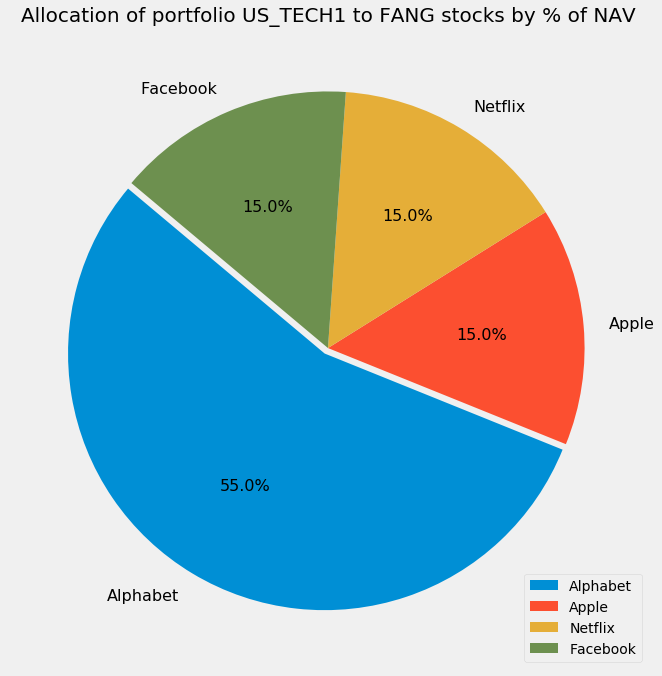

In [13]:
pie_plot()

In [14]:
# Provide mappings (as above)
# Adding a $ prefix to the dict value will hardcode that value into the LUSID call
# In the example below, we only want to set holdings, we are not concerned about the cash impact.
# Therefore we set the portfolio_cost and cost.amount to 0

mapping_required = {
    "name": "instrument_name",
    "effective_at": "effective_at",
    "code": "portfolio_code",
    "tax_lots.units": "quantity",
    "tax_lots.price": "price",
    "tax_lots.portfolio_cost": "market_value",
    "tax_lots.cost.currency": "currency",
    "tax_lots.cost.amount": "market_value"
    }

identifiers = {
    "ClientInternal": "ClientInternal",
}

In [15]:
# Run the load_from_data_frame cocoon method again
# This time we upload holdings

response = cocoon.load_from_data_frame(api_factory=api_factory,
                            scope=scope,
                            data_frame=df_holdings,
                            mapping_required=mapping_required,
                            mapping_optional={},
                            file_type="holdings",
                            identifier_mapping=identifiers
)

# Step 5: Upload quotes

Next we need some quotes, to produce our valuations. In this example, the quotes will be loaded from an external CSV file.

In [16]:
quotes_csv = r"data/backtesting/backtesting_quotes.csv"
df_quotes = pd.read_csv(quotes_csv)
df_quotes.head(2)

,quote_date,client_internal,price
0,2019-01-02T00:00:00Z,EQ38475943,1045.85
1,2019-01-03T00:00:00Z,EQ38475943,1016.06


In [17]:
df_quotes.loc[df_quotes["quote_date"] == "2019-01-02T00:00:00Z"]

,quote_date,client_internal,price
0,2019-01-02T00:00:00Z,EQ38475943,1045.85
187,2019-01-02T00:00:00Z,EQ38451369,155.58
374,2019-01-02T00:00:00Z,EQ36852475,267.66
561,2019-01-02T00:00:00Z,EQ26845198,135.68


We now have the quotes in a DataFrame, which is great. However we also want to provide the LUID. To resolve this problem, we take our client_internal ID and search the APIs for a LUID which is appended to each row in the DataFrame. <br>

In [18]:
def add_luid_id(data_frame):
    
    client_ids = pd.DataFrame(list(df_holdings["ClientInternal"].unique()), columns=["client_internal"])
    client_ids["LUID"] = client_ids["client_internal"].apply(
    lambda x: api_factory.build(lusid.api.InstrumentsApi).get_instrument(
        identifier_type="ClientInternal",
        identifier=x).lusid_instrument_id)
    
    client_ids = client_ids.set_index("client_internal")
    
    data_frame['LUID'] = data_frame["client_internal"].apply(lambda x: client_ids.loc[x]["LUID"])
    
    return data_frame

In [19]:
df_quotes = add_luid_id(df_quotes)

In [20]:
# Define our mapping dictionaries

mapping_required = {
    "quote_id.quote_series_id.instrument_id_type": "$LusidInstrumentId",
    "quote_id.effective_at": "quote_date",
    "quote_id.quote_series_id.provider": "$DataScope",
    "quote_id.quote_series_id.field": "$mid",
    "quote_id.quote_series_id.quote_type": "$Price",
    "quote_id.quote_series_id.instrument_id": "LUID",
    "metric_value.unit": "$USD",
    "metric_value.value": "price"
    }

In [21]:
# Run cocoon again, this time for quotes

response = cocoon.load_from_data_frame(api_factory = api_factory,
                            scope=scope,
                            data_frame=df_quotes,
                            mapping_required=mapping_required,
                            mapping_optional={},
                            file_type="quotes"
)

prettyprint.upsert_quotes_response(response["quotes"]["success"][0]).head(10)

,_lineage,_cut_label,_uploaded_by,_as_at,discriminator,_provider,_price_source,_instrument_id,_instrument_id_type,_quote_type,_field,_value,_unit,status
0,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1045.85,USD,Success
1,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1016.06,USD,Success
2,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1070.71,USD,Success
3,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1068.39,USD,Success
4,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1076.28,USD,Success
5,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1074.66,USD,Success
6,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1070.33,USD,Success
7,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1057.19,USD,Success
8,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1044.69,USD,Success
9,,,00u55ere4tih6q8Fl2p7,2019-12-13 16:12:34.445542+00:00,None,DataScope,None,LUID_584X4HH9,LusidInstrumentId,Price,mid,1077.15,USD,Success


# Step 6: Run aggregration on portfolio

Now we have all our data in LUSID to produce a valuation. Let's see how well our portfolio performed between 1 Jan and 30 Sep. Was it a good idea to allocate 55% to Google?

In [22]:
# Create an aggregration function
# This function takes two parameters of data and portfolio_code
# It returns a valuation of the portfolio for the date
# The return is a list of format [portfolio, date, valuation]
# Example [TECH_PORTFOLIO, 2019-10-10, 10000000]

def run_agg(date, portfolio_code):

    inline_recipe = models.ConfigurationRecipe(
        code='quotes_recipe',
        market=models.MarketContext(
            market_rules=[
                models.MarketDataKeyRule(
                   key='Equity.LusidInstrumentId.*',
                   supplier='DataScope',
                   data_scope=scope,
                   quote_type='Price',
                   field='Mid')
            ],
            suppliers=models.MarketContextSuppliers(
                commodity='DataScope',
                credit='DataScope',
                equity='DataScope',
                fx='DataScope',
                rates='DataScope'),
            options=models.MarketOptions(
                default_supplier='DataScope',
                default_instrument_code_type='LusidInstrumentId',
                default_scope=scope)
            )
        )
    
    aggregation_request = models.AggregationRequest(
    inline_recipe=inline_recipe,
    effective_at= date,
    metrics=[
        models.AggregateSpec(key='Holding/default/SubHoldingKey',
        op='Value'),
        models.AggregateSpec(key='Holding/default/Cost',
        op='Sum'),
        models.AggregateSpec(key='Holding/default/PV',
        op='Sum'),
        models.AggregateSpec(key='Holding/default/Units',
        op='Sum'),
        models.AggregateSpec(key='Instrument/default/Name',
        op='Value')
    ],
    group_by=[
        'Instrument/default/Name'
    ])
    
    try:
        
        response = api_factory.build(lusid.api.AggregationApi
                                ).get_aggregation_by_portfolio(
            scope, portfolio_code, request=aggregation_request)
        
        return [portfolio_code, date, sum([item["Sum(Holding/default/PV)"] for item in response.data])]
    
    except:
        pass

In [23]:
# Next we extend the function above to provide the valuation over a time-series
# The function returns a DataFrame where each row is a row shows portfolio and valuation for a given date
# The index is the valuation date

def run_agg_ts(start_date, end_date, porfolio_code):
    
    results_list = []
    
    for date in pd.date_range(start_date, end_date):
        results_list.append(run_agg(date, porfolio_code))
        
    agg_df = pd.DataFrame(results_list, columns = ["Portfolio", "Date", "MarketValue"])    
    agg_df["Date"] = agg_df["Date"].apply(lambda x: x.replace(tzinfo=None))
    agg_df = agg_df.set_index("Date")
    agg_df["MarketValue"] = (agg_df["MarketValue"] / 1000000)
        
    return agg_df

# Step 7: Plot results of portfolio 

Plot the results of the DataFrame in a nice time-series. We can see our performance was good. The NAV of the portfolio when from 100 million USD on 1 Jan to just under 120 million USD on 30 Sep.

In [24]:
# Get Q1 data

portfolioA_df_q1 = run_agg_ts("2019-01-02T00:00:00Z", "2019-03-31T00:00:00Z", portfolioA)

In [25]:
# Get Q2 data

portfolioA_df_q2 = run_agg_ts("2019-03-01T00:00:00Z", "2019-06-30T00:00:00Z", portfolioA)

In [26]:
# Get Q3 data

portfolioA_df_q3 = run_agg_ts("2019-07-01T00:00:00Z", "2019-09-30T00:00:00Z", portfolioA)

In [27]:
# Merge Q1, Q2, and Q3

portfolioA_df = pd.concat([portfolioA_df_q1, portfolioA_df_q2, portfolioA_df_q3])

In [28]:
def time_series_performance():
    ts_performance = portfolioA_df.plot(y=["MarketValue"], figsize=(12,9))
    ts_performance.set_title(f"NAV of portfolio {portfolioA} from 01-01-2019 to 30-09-2019", fontsize="large")
    ts_performance.set_ylabel('NAV in millions of $', fontsize="large")
    ts_performance.set_xlabel('Time: Jan to Sep 2019', fontsize="large")
    ts_performance.legend(prop={'size': 12})

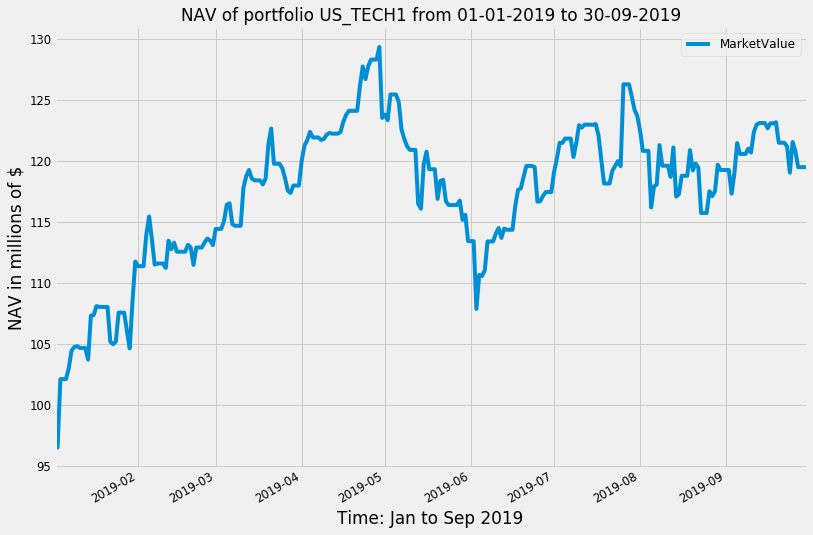

In [29]:
time_series_performance()

# Step 8: Did we make the right allocation choice?

What would have happened is we allocated 55% of portfolio NAV to Netflix instead of Google. How would that have impacted our portfolio's performance? Fortunately, we can check that easily using LUSID's derived portfolios functionality.<br>

First lets create a derived portfolio from the parent portfolio which is portfolioA above. The derived portfolio will inherit all the holdings of the parent portfolio. See our page on [derived portfolios](https://support.lusid.com/what-is-a-derived-portfolio) to learn more about this portfolio type.

In [30]:
def create_derived_portfolio(new_port, parent_port):
    
    derived_api = api_factory.build(lusid.api.DerivedTransactionPortfoliosApi)
    
    derived_request = lusid.models.CreateDerivedTransactionPortfolioRequest(
        display_name=f"Derived Portfolio of {parent_port}",
        code=new_port,
        parent_portfolio_id=lusid.models.ResourceId(scope=scope, code=parent_port),
        description = "US Tech Strategy",
        created = "2019-01-01T00:00:00Z")
    
    try:
        api_factory.build(lusid.api.PortfoliosApi).get_portfolio(
            scope=scope,
            code=new_port)
        
        print (f"Portfolio {new_port} already exists in LUSID")
    
    except lusid.exceptions.ApiException as e:
        if e.status == 404:
            response = derived_api.create_derived_portfolio(scope=scope, portfolio = derived_request)   

In [31]:
create_derived_portfolio(portfolioB, portfolioA)

Portfolio US_TECH2 already exists in LUSID


Next let's calculate the holding adjustments required to rebalance 55% of NAV to Netflix.

In [32]:
def rebalance_port(scope, portfolioA, effective_at, adjustment):
    
    holdings_response = api_factory.build(lusid.api.TransactionPortfoliosApi).get_holdings(scope, 
                                                                   portfolioA, 
                                                                   effective_at=effective_at).values
    
    rebal_holdings = pd.DataFrame([[holding.cost_portfolio_ccy.amount, 
                                  holding.instrument_uid, 
                                  holding.units] for holding in holdings_response],
                               columns = ["market_value", "LUID", "units"])
    
    rebal_holdings["client_internal"] = rebal_holdings["LUID"].apply(
    lambda x: api_factory.build(lusid.api.InstrumentsApi).get_instrument(
        identifier_type="LusidInstrumentId",
        identifier=x).identifiers["ClientInternal"])
    
    rebal_holdings["instrument_name"] = rebal_holdings["LUID"].apply(
    lambda x: api_factory.build(lusid.api.InstrumentsApi).get_instrument(
        identifier_type="LusidInstrumentId",
        identifier=x).name)
    
    rebal_holdings["Ticker"] = rebal_holdings["LUID"].apply(
    lambda x: api_factory.build(lusid.api.InstrumentsApi).get_instrument(
        identifier_type="LusidInstrumentId",
        identifier=x).identifiers["Ticker"])
    
    rebal_holdings["pct_mv"] = rebal_holdings["market_value"] / sum(rebal_holdings["market_value"],0)
    
    rebal_holdings["target_pct_mv"] = rebal_holdings["pct_mv"]
    for client_internal, value in adjustment:
        rebal_holdings.loc[rebal_holdings["client_internal"] == client_internal, "target_pct_mv"] = value
        
    rebal_holdings["target_units"] = (rebal_holdings["target_pct_mv"] / rebal_holdings["pct_mv"]
                                       *rebal_holdings["units"])

    return rebal_holdings

Running the rebalance function below, we can see the new target units for GOOG and NFLX:

In [33]:
rebalanced_portfolio = rebalance_port(scope, portfolioA, "2019-01-01T00:00:02Z", [("EQ38475943", 0.15), ("EQ36852475", 0.55)])
rebalanced_portfolio[["Ticker","target_pct_mv","target_units"]].set_index("Ticker")

,target_pct_mv,target_units
Ticker,,
GOOG,0.15,14354.12
AAPL,0.15,94985.00
NFLX,0.55,205485.33
FB,0.15,110554.00


The new % NAVs can be plotted on a pie-chart so we can visualise the results:

In [34]:
def rebalanced_portfolio_pie():
    plt.style.use('fivethirtyeight')
    rebalanced_portfolio_pie = rebalanced_portfolio.plot.pie(y="target_pct_mv",
                        labels=rebalanced_portfolio["instrument_name"].values,
                        figsize=(11, 11),
                        title=f"Allocation of portfolio {portfolioA} to FANG stocks by % of NAV",
                        explode=(0.025, 0, 0, 0),
                        startangle=140,
                        autopct='%1.1f%%',
                        textprops={'fontsize': 16})

    rebalanced_portfolio_pie.set_ylabel('')
    rebalanced_portfolio_pie.legend(loc=4,prop={'size':14})
    rebalanced_portfolio_pie.set_title(f"Rebalanced allocation of portfolio {portfolioA} to FANG stocks by % of NAV", 
                                       fontsize=20)

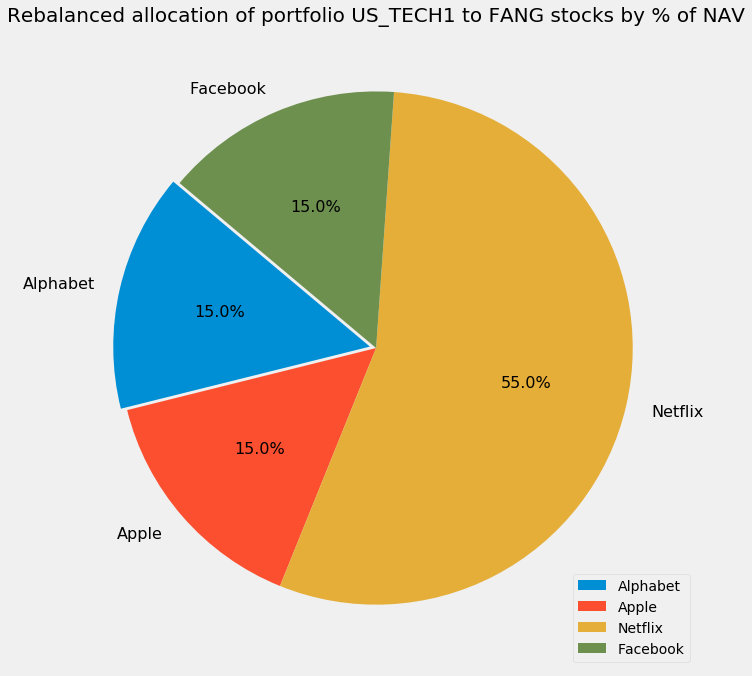

In [35]:
rebalanced_portfolio_pie()

Once we're happy with the rebalance quantities, these adjustments can be processed in LUSID using the Adjust Holdings APIs:

In [36]:
def holding_adj_request(holdings):
    
    holding_adj_request = []
    
    for instrument, units in holdings:

        holding_adj_request.append(lusid.models.AdjustHoldingRequest(
        instrument_identifiers={"instrument/default/ClientInternal": f"{instrument}"},
        tax_lots= [lusid.models.TargetTaxLotRequest(units=units,
                                                   portfolio_cost=None,
                                                   cost=lusid.models.CurrencyAndAmount(None, "USD"),
                                                   price=None,
                                                   purchase_date="2019-01-01T00:00:00Z",
                                                   settlement_date="2019-01-01T00:00:00Z"
        )]
        ))
        
    return holding_adj_request

In [37]:
holdings = [("EQ38475943", 14390), 
            ("EQ36852475", 206009)]

holding_adjustment = holding_adj_request(holdings)

In [38]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).adjust_holdings(
    scope, 
    portfolioB, 
    effective_at="2019-01-01T10:00:00Z",
    holding_adjustments=holding_adjustment)

Then rerun our aggregration functions and plot results against each other:

In [39]:
# Get Q1 data

portfolioB_df_q1 = run_agg_ts("2019-01-02T00:00:00Z", "2019-03-31T00:00:00Z", portfolioB)

In [40]:
# Get Q2 data

portfolioB_df_q2 = run_agg_ts("2019-03-01T00:00:00Z", "2019-06-30T00:00:00Z", portfolioB)

In [41]:
# Get Q3 data

portfolioB_df_q3 = run_agg_ts("2019-07-01T00:00:00Z", "2019-09-30T00:00:00Z", portfolioB)

In [42]:
# Merge results into one DataFrame

portfolioB_df = pd.concat([portfolioB_df_q1, portfolioB_df_q2, portfolioB_df_q3])

In [43]:
port_joined_df = portfolioA_df.join(portfolioB_df, lsuffix =portfolioA, rsuffix=portfolioB)
port_joined_df.rename(columns={"MarketValueUS_TECH1":"Portfolio weighted 55% to Alphabet Inc", 
                               "MarketValueUS_TECH2": "Portfolio weighted 55% to Netflix"}, inplace=True)
port_joined_df.head(2)

,PortfolioUS_TECH1,Portfolio weighted 55% to Alphabet Inc,PortfolioUS_TECH2,Portfolio weighted 55% to Netflix
Date,,,,
2019-01-02,US_TECH1,99.82,US_TECH2,99.97
2019-01-03,US_TECH1,96.55,US_TECH2,98.36


# Step 9: Check results

Looking at the time-series of results below, we can see we were correct to allocate 55% to Google versus Netflix in first 3Q of 2019.

In [44]:
def time_series_performance_all():
    ts_performance_all = port_joined_df.plot(y=[port_joined_df.columns[1], port_joined_df.columns[3]], figsize=(12,9))
    ts_performance_all.set_title('NAV of portfolios from 01-01-2019 to 30-09-2019', fontsize="large")
    ts_performance_all.set_ylabel('NAV in millions of $', fontsize="large")
    ts_performance_all.set_xlabel('Time: Jan to Sep 2019', fontsize="large")
    ts_performance_all.legend(prop={'size': 12})

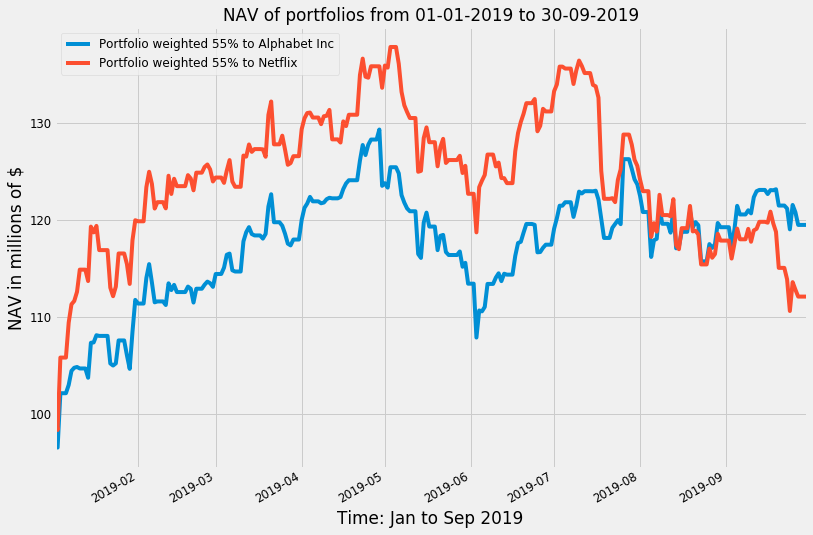

In [45]:
time_series_performance_all()